In [8]:
import tushare as ts
import pandas as pd
import time
pro = ts.pro_api('7e33b6a3e2bad955cd087c9e5a6e69ad34dc797daee4ff6de9cb08f7')
import datetime
import os
from datetime import datetime
from datetime import date
from numpy import *
from datetime import timedelta
from tabulate import tabulate
import numpy as np
# Math & Optimization
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import curve_fit
# Plotting
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Data Manipulation
from datetime import timedelta
from tabulate import tabulate

In [10]:
def time_index(df):
    times = df['trade_date'].astype(str)
    formatStr = '%Y-%m-%d'
    df.index = pd.to_datetime(times,format=formatStr)
    df = df.drop(columns=['trade_date'])
    return df

### Treasure bond yields to maturity(4.10)

In [11]:
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [12]:
yield_maturities = np.array([1/12,2/12,3/12,6/12,9/12,1,2,3,4,5,7,10,15,20,30])
yields = np.array([0.01831,0.0184,0.01873,0.02061,0.0217,0.0223,0.0241,0.0250,0.026,0.0269,0.0282,0.0285,0.0299,0.0307,0.0323])

In [13]:
curve_fit,status = calibrate_nss_ols(yield_maturities,yields)

curve_fit

NelsonSiegelSvenssonCurve(beta0=0.036021262050718414, beta1=-0.01798380343542376, beta2=0.009032416406851186, beta3=-0.018988040138814544, tau1=2.0, tau2=5.0)

In [14]:
def get_data(date,option_type,dividends):
    ### fetching the contracts information from SSE
    df_exchange = pro.opt_basic(exchange='SSE', fields='ts_code,name,call_put,exercise_price,list_date,delist_date')
    df_300ETF = df_exchange.loc[df_exchange['name'].str.contains('500ETF')]
    df = df_300ETF.sort_values(by='list_date',ascending = True)
    opt_list =  df['ts_code'].tolist()
    
    ### daily data
    data = pro.opt_daily(trade_date=date,exchange = 'SSE')
    data_opt = data[data['ts_code'].isin(opt_list)]
    df1 = pd.merge(df,data_opt,how='right',on=['ts_code'])
    
    ### 300etf data
    d300_etf = pro.fund_daily(ts_code='510500.SH', trade_date = date,fields = 'close')
    underlying = d300_etf.iloc[0, 0]
    df1['s'] = underlying
    
    ### futures data
    df_f = pro.fut_daily(ts_code='IC.CFX', trade_date = date,fields = 'close')
    f = df_f.iloc[0, 0]
    #df1['f'] = f
    df1['f'] = underlying
    ### risk free rate
    df_shibor = pro.shibor(date = date,fields = '1w')
    rf = df_shibor.iloc[0, 0]
    df1['risk_free'] = rf/100
    
    ### date to expiration
    T_t = []
    for i in range(df1.shape[0]):
        dt = int((datetime.strptime(df1.delist_date[i],'%Y%m%d')- datetime.strptime(df1.trade_date[i],'%Y%m%d')).days)/365
        T_t.append(dt)
    df1['T_t'] = T_t
    
    ### dividend rate
    #def iq(df): # 计算隐含分红率
        #q = -log((df.settle+df.exercise_price*exp(-df.risk_free*df.T_t)-df.settle_p)/(df.s))/df.T_t
        #return q
    
    df_c = df1[df1['call_put']=='C']
    df_p = df1[df1['call_put']=='P']
    df_p = df_p.rename(columns={'close':'close_p','ts_code':'ts_code_p','call_put':'call_put_p'})
    df_m = pd.merge(df_c,df_p,how='left',on=['trade_date','exercise_price','T_t','risk_free','s'])
    #df_m['d'] = df_m.apply(iq,axis = 1).fillna(0)
    df_m['d'] = dividends
    
    ### choose option type
    df_opt = df1[df1['call_put'] == option_type]
    
    df_option = df_opt.loc[:,['ts_code','exercise_price','close','risk_free','T_t','s','f']]
    df_option['d'] = df_m['d'].to_list()
    
    return df_option

In [15]:
df = get_data(date='20250117',option_type='C',dividends=0.015737)
df

,ts_code,exercise_price,close,risk_free,T_t,s,f,d
0,10007631.SH,4.230,1.3602,0.02039,0.186301,5.581,5.581,0.015737
1,10007632.SH,4.329,1.1671,0.02039,0.186301,5.581,5.581,0.015737
2,10007633.SH,4.427,1.0707,0.02039,0.186301,5.581,5.581,0.015737
3,10007634.SH,4.525,1.0707,0.02039,0.186301,5.581,5.581,0.015737
4,10007635.SH,4.624,0.9594,0.02039,0.186301,5.581,5.581,0.015737
...,...,...,...,...,...,...,...,...
170,10008771.SH,5.500,0.3572,0.02039,0.435616,5.581,5.581,0.015737
171,10008772.SH,5.750,0.2504,0.02039,0.435616,5.581,5.581,0.015737
172,10008773.SH,6.000,0.1823,0.02039,0.435616,5.581,5.581,0.015737
173,10008774.SH,6.250,0.1298,0.02039,0.435616,5.581,5.581,0.015737


In [16]:
class BS:
    
    """
    This is a class for Options contract for pricing European options on stocks/index with dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
        callprice     : int or float [default None]
        putprice      : int or float [default None]
    """    
    
    def __init__(self, spot, strike, rate, dte, volatility, dividends, callprice=None, putprice=None):
        
        # Spot Price
        self.spot = spot
        
        # Option Strike
        self.strike = strike
        
        # Interest Rate
        self.rate = rate
        
        # Days To Expiration
        self.dte = dte
        
        # Volatlity
        self.volatility = volatility
        
        # Dividends
        self.dividends = dividends
        
        # Callprice
        self.callprice = callprice
        
        # Putprice
        self.putprice = putprice
            
        # Utility 
        self._a_ = self.volatility * self.dte**0.5
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (log(self.spot / self.strike) + \
                     (self.rate - self.dividends + (self.volatility**2) / 2) * self.dte) / self._a_
        
        self._d2_ = self._d1_ - self._a_
        
        self._b_ = e**-(self.rate * self.dte)
        
        
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', \
                  'callRho', 'putRho', 'vega', 'gamma', 'impvol','vanna','DvannaDvol','charm',\
                  'zomma','speed','color','vomma','ultima','DvegaDtime']:
            self.__dict__[i] = None
        
        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()
        self.impvol = self._impvol()
        self.vanna = self._vanna()
        self.DvannaDvol = self._DvannaDvol()
        [self.callcharm, self.putcharm] = self._charm()
        self.zomma = self._Zomma()
        self.speed = self._speed()
        self.color = self._color()
        self.vomma = self._vomma()
        self.ultima = self._ultima()
        self.DvegaDtime = self._DvegaDtime()
    
    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * e**(-self.dividends * self.dte) * norm.cdf(self._d1_) - self.strike * e**(-self.rate * \
                                                                       self.dte) * norm.cdf(self._d2_)

            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                                                                        self.spot * e**(-self.dividends * self.dte) * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = e**(-self.dividends * self.dte) * norm.cdf(self._d1_)
            #put = -norm.cdf(-self._d1_) * e**(-self.dividends * self.dte)
            put = (norm.cdf(self._d1_)-1) * e**(-self.dividends * self.dte)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        '''Returns the option gamma'''
        return (e**(-self.dividends * self.dte) * norm.pdf(self._d1_))/ (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 * e**(-self.dividends * self.dte)

    # Option Theta
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * e**(-self.dividends * self.dte) * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_) + self.dividends*self.spot* norm.cdf(self._d1_)*e**(-self.dividends * self.dte)

        put = -self.spot * e**(-self.dividends * self.dte) * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_) - self.dividends*self.spot* norm.cdf(self._d1_)*e**(-self.dividends * self.dte)
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_)
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_)

        return [call, put]
    
    # Option Implied Volatility
    def _impvol(self):
        '''Returns the option implied volatility'''
        if (self.callprice or self.putprice) is None:
            return self.volatility
        else:
            def f(sigma):
                option = BS(self.spot,self.strike,self.rate,self.dte,sigma,self.dividends)
                if self.callprice:
                    return option.callPrice - self.callprice
                if self.putprice and not self.callprice:
                    return option.putPrice - self.putprice

            return maximum(1e-5, fsolve(f, 0.2)[0])
        
    # Option Vanna/dVega/dspot
    def _vanna(self):
        '''Return the option vanna'''
        return (-e**(-self.dividends* self.dte)*self._d2_)*norm.pdf(self._d1_)/self.volatility
    
    # Option Dvanna/Dvol
    def _DvannaDvol(self):
        '''Return the option DvannaDvol'''
        return self.vanna*(1/self.volatility)*(self._d1_*self._d2_-self._d1_/self._d2_-1)
    
    # Opiton Charm
    def _charm(self):
        '''Return the option charm'''
        call = -e**(self.dividends*self.dte)*(norm.pdf(self._d1_)*(self.rate/self.volatility*(self.dte**0.5)- \
                    self._d2_/(2*self.dte)) + (-self.dividends*norm.cdf(self._d1_)))
        put =  -e**(self.dividends*self.dte)*(norm.pdf(self._d1_)*(self.rate/self.volatility*(self.dte**0.5)- \
                    self._d2_/(2*self.dte)) - (-self.dividends*norm.cdf(-self._d1_)))
        return [call,put]
    
    # Option Zomma
    def _Zomma(self):
        '''Return the option Zomma'''
        return self.gamma*((self._d1_*self._d2_ - 1)/self.volatility)
    
    # Option speed
    def _speed(self):
        '''Return the option speed'''
        return -self.gamma*(1 + self._d1_/self.volatility*self.dte**0.5)/self.spot
    # Option color
    def _color(self):
        '''Return the option color'''
        return self.gamma*(self.dividends + (self.rate-self.dividends)*self._d1_/self.volatility*self.dte**0.5 + \
                          (1-self._d1_*self._d2_/2*self.dte))
    # Opiton vomma
    def _vomma(self):
        '''Return the option Vomma'''
        return self.vega*(self._d1_*self._d2_/self.volatility)
    
    # Opition Ultima
    def _ultima(self):
        '''Return the option ultima'''
        return self.vomma*(1/self.volatility)*(self._d1_*self._d2_-self._d1_/self._d2_- \
                            self._d2_/self._d1_ - 1)
    # Option DvegaDtime
    def _DvegaDtime(self):
        '''Return the option DvegaDtime'''
        return self.vega*(self.dividends + (self.rate - self.dividends)*self._d1_/(self.volatility*self.dte**0.5)-\
                         (1+self._d1_*self._d2_/2*self.dte))

In [17]:
def cal_iv(df,option_type,rv):
    option_list = df.ts_code.tolist()

    df = df.set_index('ts_code')
    imv_list = []
    deltas_list=[]
    gammas_list=[]
    thetas_list=[]
    vegas_list=[]
    rhos_list=[]
    tv_list = []
    vanna_list = []
    DvannaDvol_list = []
    charm_list = []
    zomma_list = []
    speed_list = []
    color_list = []
    vomma_list = []
    ultima_list = []
    DvegaDtime_list = []

    for option in option_list:
        s = df.loc[option,'s']
        k = df.loc[option,'exercise_price']
        t = df.loc[option,'T_t']
        r = df.loc[option,'risk_free']
        c = df.loc[option,'close']
        d = df.loc[option,'d']
        rv = rv
        if option_type == 'C':
            options = BS(s,k,r,t,0.2,d,callprice=c)
            delta = options.callDelta
            deltas_list.append(delta)
            
            theta = options.callTheta
            thetas_list.append(theta)
            
            rho = options.callRho
            rhos_list.append(rho)
            
            tv = BS(s,k,r,t,rv,d).callPrice
            tv_list.append(tv)
            
            vanna = options.vanna
            vanna_list.append(vanna)
            
            DvannaDvol = options.DvannaDvol
            DvannaDvol_list.append(DvannaDvol)
            
            charm = options.callcharm
            charm_list.append(charm)
            
            zomma = options.zomma
            zomma_list.append(zomma)
            
            speed = options.speed
            speed_list.append(speed)
            
            color = options.color
            color_list.append(color)
            
            vomma = options.vomma
            vomma_list.append(vomma)
            
            ultima = options.ultima
            ultima_list.append(ultima)
            
            DvegaDtime = options.DvegaDtime
            DvegaDtime_list.append(DvegaDtime)
            
            
        else:
            options = BS(s,k,r,t,0.2,d,putprice=c)
            delta = options.putDelta
            deltas_list.append(delta)
            
            theta = options.putTheta
            thetas_list.append(theta)
            
            rho = options.putRho
            rhos_list.append(rho)
            
            tv = BS(s,k,r,t,rv,d).putPrice
            tv_list.append(tv)
            
            vanna = options.vanna
            vanna_list.append(vanna)
            
            DvannaDvol = options.DvannaDvol
            DvannaDvol_list.append(DvannaDvol)
            
            charm = options.putcharm
            charm_list.append(charm)
            
            zomma = options.zomma
            zomma_list.append(zomma)
            
            speed = options.speed
            speed_list.append(speed)
            
            color = options.color
            color_list.append(color)
            
            vomma = options.vomma
            vomma_list.append(vomma)
            
            ultima = options.ultima
            ultima_list.append(ultima)
            
            DvegaDtime = options.DvegaDtime
            DvegaDtime_list.append(DvegaDtime)
            
        imv = options.impvol
        imv_list.append(imv)
        
        gamma = options.gamma
        gammas_list.append(gamma)
        
        vega = options.vega
        vegas_list.append(vega)
        
        
    df['imv'] = imv_list
    df['delta'] = deltas_list 
    df['gamma'] = gammas_list
    df['theta'] = thetas_list
    df['vega'] = vegas_list
    df['rho'] = rhos_list
    df['tv'] = tv_list
    df['vanna'] = vanna_list
    df['DvannaDvol'] = DvannaDvol_list
    df['charm'] = charm_list
    df['zomma'] = zomma_list
    df['speed'] = speed_list
    df['color'] = color_list
    df['vomma'] = vomma_list
    df['ultima'] = ultima_list
    df['DvegaDtime'] = DvegaDtime_list
     
    return df 

In [18]:
df2 = cal_iv(df,'C',0.2)
df2

,exercise_price,close,risk_free,T_t,s,f,d,imv,delta,gamma,...,tv,vanna,DvannaDvol,charm,zomma,speed,color,vomma,ultima,DvegaDtime
ts_code,,,,,,,,,,,,,,,,,,,,,
10007631.SH,4.230,1.3602,0.02039,0.186301,5.581,5.581,0.015737,0.350618,0.996525,0.004013,...,1.350771,-0.030718,-1.281607,0.032274,0.188042,-0.005784,0.000331,0.241522,8.900937,-0.008264
10007632.SH,4.329,1.1671,0.02039,0.186301,5.581,5.581,0.015737,0.067848,0.995708,0.009285,...,1.252265,-0.065076,-2.175894,0.050699,0.358245,-0.012420,0.002171,0.469644,13.422673,-0.017615
10007633.SH,4.427,1.0707,0.02039,0.186301,5.581,5.581,0.015737,0.060184,0.993978,0.019524,...,1.154909,-0.124645,-3.253380,0.082616,0.610390,-0.024159,0.007177,0.821691,17.468213,-0.034268
10007634.SH,4.525,1.0707,0.02039,0.186301,5.581,5.581,0.015737,0.298900,0.990577,0.037848,...,1.057860,-0.218507,-4.277043,0.132850,0.936887,-0.043121,0.018407,1.306945,19.274530,-0.061704
10007635.SH,4.624,0.9594,0.02039,0.186301,5.581,5.581,0.015737,0.184845,0.984311,0.068351,...,0.960395,-0.353329,-4.858401,0.204894,1.295346,-0.071247,0.040459,1.899963,16.992708,-0.103929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10008771.SH,5.500,0.3572,0.02039,0.435616,5.581,5.581,0.015737,0.213868,0.572236,0.527989,...,0.337323,-0.116903,2.445911,0.009802,-2.609458,-0.154582,0.536527,0.082726,-1.860258,-1.404144
10008772.SH,5.750,0.2504,0.02039,0.435616,5.581,5.581,0.015737,0.218123,0.439475,0.532226,...,0.224182,0.542346,-4.021022,-0.145956,-2.554649,-0.049845,0.534781,0.288951,-4.905613,-1.441511
10008773.SH,6.000,0.1823,0.02039,0.435616,5.581,5.581,0.015737,0.230117,0.318043,0.482248,...,0.142159,1.064148,-7.980354,-0.266820,-1.736596,0.046774,0.456990,1.830767,-25.470413,-1.389367


In [19]:
maturity = df2.sort_values('T_t')['T_t'].drop_duplicates().tolist()
maturity

[0.0136986301369863,
 0.1095890410958904,
 0.1863013698630137,
 0.43561643835616437]

In [20]:
df_near = df2[df2['T_t']== maturity[1]]

In [21]:
df_near['type'] ='C'

In [22]:
df_near

,exercise_price,close,risk_free,T_t,s,f,d,imv,delta,gamma,...,vanna,DvannaDvol,charm,zomma,speed,color,vomma,ultima,DvegaDtime,type
ts_code,,,,,,,,,,,,,,,,,,,,,
10008609.SH,4.919,0.6622,0.02039,0.109589,5.581,5.581,0.015737,0.049676,0.972605,0.161678,...,-0.562061,-4.580746,0.527988,2.154491,-0.122369,0.134177,2.022717,6.715150,-0.115695,C
10008610.SH,5.165,0.4486,0.02039,0.109589,5.581,5.581,0.015737,0.225759,0.885484,0.517839,...,-1.095058,3.679378,1.010196,0.999037,-0.278740,0.491494,2.449637,-19.809170,-0.344722,C
10008611.SH,5.411,0.2717,0.02039,0.109589,5.581,5.581,0.015737,0.237351,0.693087,0.947309,...,-0.773271,7.444273,0.707138,-3.673394,-0.312470,0.954272,0.725797,-10.143275,-0.621401,C
10008612.SH,5.657,0.1478,0.02039,0.109589,5.581,5.581,0.015737,0.245773,0.434319,1.063486,...,0.451310,-3.777916,-0.419693,-5.117754,-0.138990,1.076695,0.136316,-2.098708,-0.724437,C
10008613.SH,5.903,0.0770,0.02039,0.109589,5.581,5.581,0.015737,0.259829,0.209642,0.778621,...,1.255293,-7.660058,-1.155845,-1.153587,0.046705,0.756016,1.870231,-21.531453,-0.573809,C
10008614.SH,6.149,0.0418,0.02039,0.109589,5.581,5.581,0.015737,0.280054,0.077224,0.391543,...,1.077342,0.882485,-0.990151,2.191409,0.095097,0.347944,2.832551,-12.501441,-0.320869,C
10008615.SH,6.394,0.0242,0.02039,0.109589,5.581,5.581,0.015737,0.302368,0.022009,0.142053,...,0.545738,6.052431,-0.501136,2.263068,0.059363,0.109501,2.029854,12.028773,-0.131417,C
10008616.SH,6.640,0.0155,0.02039,0.109589,5.581,5.581,0.015737,0.328081,0.004883,0.038310,...,0.187539,4.566511,-0.172123,1.119609,0.022488,0.023782,0.895111,17.205403,-0.040300,C
10008617.SH,6.886,0.0112,0.02039,0.109589,5.581,5.581,0.015737,0.357376,0.000864,0.007967,...,0.047089,1.893631,-0.043203,0.359401,0.005975,0.003525,0.272553,9.568910,-0.009538,C


In [23]:
df3 = get_data(date='20250117',option_type='P',dividends=0.015737)
df3

,ts_code,exercise_price,close,risk_free,T_t,s,f,d
9,10007640.SH,4.230,0.0082,0.02039,0.186301,5.581,5.581,0.015737
10,10007641.SH,4.329,0.0106,0.02039,0.186301,5.581,5.581,0.015737
11,10007642.SH,4.427,0.0130,0.02039,0.186301,5.581,5.581,0.015737
12,10007643.SH,4.525,0.0165,0.02039,0.186301,5.581,5.581,0.015737
13,10007644.SH,4.624,0.0215,0.02039,0.186301,5.581,5.581,0.015737
...,...,...,...,...,...,...,...,...
179,10008780.SH,5.500,0.3221,0.02039,0.435616,5.581,5.581,0.015737
180,10008781.SH,5.750,0.4666,0.02039,0.435616,5.581,5.581,0.015737
181,10008782.SH,6.000,0.6822,0.02039,0.435616,5.581,5.581,0.015737
182,10008783.SH,6.250,0.9020,0.02039,0.435616,5.581,5.581,0.015737


In [24]:
#df3 = get_data(date='20250106',option_type='P',dividends=0.015737)
df4 = cal_iv(df3,'P',0.2)
df4

,exercise_price,close,risk_free,T_t,s,f,d,imv,delta,gamma,...,tv,vanna,DvannaDvol,charm,zomma,speed,color,vomma,ultima,DvegaDtime
ts_code,,,,,,,,,,,,,,,,,,,,,
10007640.SH,4.230,0.0082,0.02039,0.186301,5.581,5.581,0.015737,0.341787,-0.000548,0.004013,...,0.000072,-0.030718,-1.281607,0.016491,0.188042,-0.005784,0.000331,0.241522,8.900937,-0.008264
10007641.SH,4.329,0.0106,0.02039,0.186301,5.581,5.581,0.015737,0.332296,-0.001364,0.009285,...,0.000191,-0.065076,-2.175894,0.034916,0.358245,-0.012420,0.002171,0.469644,13.422673,-0.017615
10007642.SH,4.427,0.0130,0.02039,0.186301,5.581,5.581,0.015737,0.319976,-0.003095,0.019524,...,0.000463,-0.124645,-3.253380,0.066833,0.610390,-0.024159,0.007177,0.821691,17.468213,-0.034268
10007643.SH,4.525,0.0165,0.02039,0.186301,5.581,5.581,0.015737,0.309895,-0.006495,0.037848,...,0.001042,-0.218507,-4.277043,0.117067,0.936887,-0.043121,0.018407,1.306945,19.274530,-0.061704
10007644.SH,4.624,0.0215,0.02039,0.186301,5.581,5.581,0.015737,0.301554,-0.012761,0.068351,...,0.002201,-0.353329,-4.858401,0.189110,1.295346,-0.071247,0.040459,1.899963,16.992708,-0.103929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10008780.SH,5.500,0.3221,0.02039,0.435616,5.581,5.581,0.015737,0.253186,-0.420932,0.527989,...,0.245816,-0.116903,2.445911,-0.006044,-2.609458,-0.154582,0.536527,0.082726,-1.860258,-1.404144
10008781.SH,5.750,0.4666,0.02039,0.435616,5.581,5.581,0.015737,0.259379,-0.553693,0.532226,...,0.380464,0.542346,-4.021022,-0.161801,-2.554649,-0.049845,0.534781,0.288951,-4.905613,-1.441511
10008782.SH,6.000,0.6822,0.02039,0.435616,5.581,5.581,0.015737,0.299220,-0.675125,0.482248,...,0.546231,1.064148,-7.980354,-0.282665,-1.736596,0.046774,0.456990,1.830767,-25.470413,-1.389367


In [25]:
df_nearP = df4[df4['T_t']== maturity[1]]
df_nearP

,exercise_price,close,risk_free,T_t,s,f,d,imv,delta,gamma,...,tv,vanna,DvannaDvol,charm,zomma,speed,color,vomma,ultima,DvegaDtime
ts_code,,,,,,,,,,,,,,,,,,,,,
10008618.SH,4.919,0.0214,0.02039,0.109589,5.581,5.581,0.015737,0.288401,-0.025672,0.161678,...,0.003681,-0.562061,-4.580746,0.512224,2.154491,-0.122369,0.134177,2.022717,6.715150,-0.115695
10008619.SH,5.165,0.0503,0.02039,0.109589,5.581,5.581,0.015737,0.269471,-0.112793,0.517839,...,0.020824,-1.095058,3.679378,0.994432,0.999037,-0.278740,0.491494,2.449637,-19.809170,-0.344722
10008620.SH,5.411,0.1192,0.02039,0.109589,5.581,5.581,0.015737,0.266968,-0.305190,0.947309,...,0.074653,-0.773271,7.444273,0.691374,-3.673394,-0.312470,0.954272,0.725797,-10.143275,-0.621401
10008621.SH,5.657,0.2403,0.02039,0.109589,5.581,5.581,0.015737,0.272447,-0.563958,1.063486,...,0.187442,0.451310,-3.777916,-0.435457,-5.117754,-0.138990,1.076695,0.136316,-2.098708,-0.724437
10008622.SH,5.903,0.4130,0.02039,0.109589,5.581,5.581,0.015737,0.287879,-0.788635,0.778621,...,0.360928,1.255293,-7.660058,-1.171609,-1.153587,0.046705,0.756016,1.870231,-21.531453,-0.573809
10008623.SH,6.149,0.6264,0.02039,0.109589,5.581,5.581,0.015737,0.322940,-0.921053,0.391543,...,0.576414,1.077342,0.882485,-1.005915,2.191409,0.095097,0.347944,2.832551,-12.501441,-0.320869
10008624.SH,6.394,0.8501,0.02039,0.109589,5.581,5.581,0.015737,0.351367,-0.976268,0.142053,...,0.811302,0.545738,6.052431,-0.516900,2.263068,0.059363,0.109501,2.029854,12.028773,-0.131417
10008625.SH,6.640,1.0900,0.02039,0.109589,5.581,5.581,0.015737,0.400789,-0.993394,0.038310,...,1.054354,0.187539,4.566511,-0.187887,1.119609,0.022488,0.023782,0.895111,17.205403,-0.040300
10008626.SH,6.886,1.3325,0.02039,0.109589,5.581,5.581,0.015737,0.450153,-0.997413,0.007967,...,1.299333,0.047089,1.893631,-0.058967,0.359401,0.005975,0.003525,0.272553,9.568910,-0.009538


In [26]:
df_nearP['type'] ='P'

In [27]:
df_nearP

,exercise_price,close,risk_free,T_t,s,f,d,imv,delta,gamma,...,vanna,DvannaDvol,charm,zomma,speed,color,vomma,ultima,DvegaDtime,type
ts_code,,,,,,,,,,,,,,,,,,,,,
10008618.SH,4.919,0.0214,0.02039,0.109589,5.581,5.581,0.015737,0.288401,-0.025672,0.161678,...,-0.562061,-4.580746,0.512224,2.154491,-0.122369,0.134177,2.022717,6.715150,-0.115695,P
10008619.SH,5.165,0.0503,0.02039,0.109589,5.581,5.581,0.015737,0.269471,-0.112793,0.517839,...,-1.095058,3.679378,0.994432,0.999037,-0.278740,0.491494,2.449637,-19.809170,-0.344722,P
10008620.SH,5.411,0.1192,0.02039,0.109589,5.581,5.581,0.015737,0.266968,-0.305190,0.947309,...,-0.773271,7.444273,0.691374,-3.673394,-0.312470,0.954272,0.725797,-10.143275,-0.621401,P
10008621.SH,5.657,0.2403,0.02039,0.109589,5.581,5.581,0.015737,0.272447,-0.563958,1.063486,...,0.451310,-3.777916,-0.435457,-5.117754,-0.138990,1.076695,0.136316,-2.098708,-0.724437,P
10008622.SH,5.903,0.4130,0.02039,0.109589,5.581,5.581,0.015737,0.287879,-0.788635,0.778621,...,1.255293,-7.660058,-1.171609,-1.153587,0.046705,0.756016,1.870231,-21.531453,-0.573809,P
10008623.SH,6.149,0.6264,0.02039,0.109589,5.581,5.581,0.015737,0.322940,-0.921053,0.391543,...,1.077342,0.882485,-1.005915,2.191409,0.095097,0.347944,2.832551,-12.501441,-0.320869,P
10008624.SH,6.394,0.8501,0.02039,0.109589,5.581,5.581,0.015737,0.351367,-0.976268,0.142053,...,0.545738,6.052431,-0.516900,2.263068,0.059363,0.109501,2.029854,12.028773,-0.131417,P
10008625.SH,6.640,1.0900,0.02039,0.109589,5.581,5.581,0.015737,0.400789,-0.993394,0.038310,...,0.187539,4.566511,-0.187887,1.119609,0.022488,0.023782,0.895111,17.205403,-0.040300,P
10008626.SH,6.886,1.3325,0.02039,0.109589,5.581,5.581,0.015737,0.450153,-0.997413,0.007967,...,0.047089,1.893631,-0.058967,0.359401,0.005975,0.003525,0.272553,9.568910,-0.009538,P


In [28]:
df_near['diff'] = df_near['f'] - df_near['exercise_price']
near_term_c = df_near[df_near['type']== 'C'].sort_values(by='exercise_price')
k0_index_c = np.argmin(abs(near_term_c['diff']))
atm_call = near_term_c.loc[[near_term_c.index[k0_index_c]]]

In [29]:
atm_call

,exercise_price,close,risk_free,T_t,s,f,d,imv,delta,gamma,...,DvannaDvol,charm,zomma,speed,color,vomma,ultima,DvegaDtime,type,diff
ts_code,,,,,,,,,,,,,,,,,,,,,
10008612.SH,5.657,0.1478,0.02039,0.109589,5.581,5.581,0.015737,0.245773,0.434319,1.063486,...,-3.777916,-0.419693,-5.117754,-0.13899,1.076695,0.136316,-2.098708,-0.724437,C,-0.076


In [30]:
df_nearP['diff'] = df_nearP['f'] - df_nearP['exercise_price']
near_term_p = df_nearP[df_nearP['type']== 'P'].sort_values(by='exercise_price')
k0_index_p = np.argmin(abs(near_term_p['diff']))
atm_put = near_term_p.loc[[near_term_p.index[k0_index_p]]]

In [31]:
atm_put

,exercise_price,close,risk_free,T_t,s,f,d,imv,delta,gamma,...,DvannaDvol,charm,zomma,speed,color,vomma,ultima,DvegaDtime,type,diff
ts_code,,,,,,,,,,,,,,,,,,,,,
10008621.SH,5.657,0.2403,0.02039,0.109589,5.581,5.581,0.015737,0.272447,-0.563958,1.063486,...,-3.777916,-0.435457,-5.117754,-0.13899,1.076695,0.136316,-2.098708,-0.724437,P,-0.076


In [32]:
K_c = []
c_n = []
for index,row in df_near.iterrows():
    if row['exercise_price'] > atm_call.loc[:,['exercise_price']].iloc[0,0]:
        K_c.append(row['exercise_price'] )
        c_n.append(near_term_c.at[index,'imv'])

for index,row in near_term_p.iterrows():
    if row['exercise_price'] < atm_put.loc[:,['exercise_price']].iloc[0,0]:
        K_c.append(row['exercise_price'] )
        c_n.append(near_term_p.at[index,'imv'])

In [33]:
K_c

[5.903,
 6.149,
 6.394,
 6.64,
 6.886,
 5.75,
 6.0,
 6.25,
 6.5,
 4.722,
 4.8,
 4.82,
 4.9,
 4.919,
 5.0,
 5.165,
 5.25,
 5.411,
 5.5]

In [34]:
c_n

[0.2598290505556239,
 0.28005387878405996,
 0.30236830866396475,
 0.32808100494341325,
 0.35737569349306497,
 0.25053371827818116,
 0.2658891798468591,
 0.28960588621230865,
 0.31081425030267146,
 0.30260890868023504,
 0.29693006769670005,
 0.29504635546071795,
 0.28889706523367137,
 0.28840063924978604,
 0.28035411325819115,
 0.26947142341164565,
 0.268826777842957,
 0.2669679545231118,
 0.2662547285804974]

In [35]:
data1 = pd.DataFrame(np.array(c_n).reshape(1,19),columns=K_c).sort_index(axis=1)

In [36]:
data1

,4.722,4.800,4.820,4.900,4.919,5.000,5.165,5.250,5.411,5.500,5.750,5.903,6.000,6.149,6.250,6.394,6.500,6.640,6.886
0,0.302609,0.29693,0.295046,0.288897,0.288401,0.280354,0.269471,0.268827,0.266968,0.266255,0.250534,0.259829,0.265889,0.280054,0.289606,0.302368,0.310814,0.328081,0.357376


In [37]:
data1[5.657] = (atm_put['imv'].values + atm_call['imv'].values)/2

In [38]:
data1[5.657]

0    0.25911
Name: 5.657, dtype: float64

In [39]:
data1 = data1.sort_index(axis=1)

In [40]:
data1

,4.722,4.800,4.820,4.900,4.919,5.000,5.165,5.250,5.411,5.500,5.657,5.750,5.903,6.000,6.149,6.250,6.394,6.500,6.640,6.886
0,0.302609,0.29693,0.295046,0.288897,0.288401,0.280354,0.269471,0.268827,0.266968,0.266255,0.25911,0.250534,0.259829,0.265889,0.280054,0.289606,0.302368,0.310814,0.328081,0.357376


In [41]:
np.array(data1.keys())

array([4.722, 4.8  , 4.82 , 4.9  , 4.919, 5.   , 5.165, 5.25 , 5.411,
       5.5  , 5.657, 5.75 , 5.903, 6.   , 6.149, 6.25 , 6.394, 6.5  ,
       6.64 , 6.886])

In [42]:
data1.values.flatten()

array([0.30260891, 0.29693007, 0.29504636, 0.28889707, 0.28840064,
       0.28035411, 0.26947142, 0.26882678, 0.26696795, 0.26625473,
       0.2591098 , 0.25053372, 0.25982905, 0.26588918, 0.28005388,
       0.28960589, 0.30236831, 0.31081425, 0.328081  , 0.35737569])

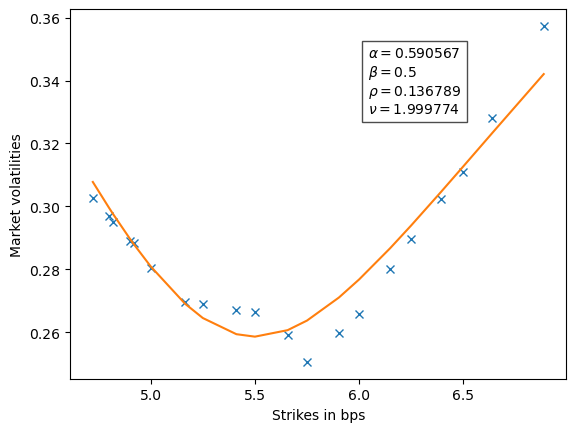

In [43]:
from scipy.optimize import curve_fit

def main(): 
    #A good fit can be obtained for any 0<=beta<=1. Often beta=0,1/2 or beta=1
    #is choosen, depending on the market.
    beta = 0.5
    #The current forward price
    f =  5.581
    #The time to the expiry of the option
    t_exp =0.109589
    #The tenor of the option
    #tenor = 0.0931
    #A list of market volatilities at strikes  
    #sigmas = np.array([ 0.29167001, 0.28468584, 0.27796866, 0.26536527, 0.24565334,
       #0.23685379, 0.24922199, 0.26602791, 0.28986523, 0.31412182,
      # 0.35259042])
    sigmas =data1.values.flatten()
    #The 'At the money volatility', corrosponding to a strike equal to the current forward price.
    atm_sigma =   0.25911
    #A list of strikes in bps (=0.0001) corrosponding to volatilites in sigmas
    #strikes_in_bps = np.array([4.8 , 4.9 , 5.  , 5.25, 5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ])
    strikes_in_bps = np.array(data1.keys())
    #An inital guess of the parameters alpha, nu and rho.
    guess = [0.01, 10,-0.5]
    
    #calculating the actual strikes from f and strikes_in_bps
    #strikes = f + strikes_in_bps*0.0001
    strikes = strikes_in_bps
    #Calling the SABR_calibration function defined below to return the parameters.
    alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas, guess)
    
    #This nextsection of code simply draws a plot.
    #Ks_in_bps = np.array(data1.keys())
    #Ks = np.array(data1.keys())
    Ks_in_bps =   np.array(data1.keys())
    Ks =   np.array(data1.keys())
    vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)
    textbox = "\n".join((r"$\alpha=$"+f"{round(alpha,6)}",r"$\beta=$"+f"{beta}",
                        r"$\rho=$"+f"{round(rho,6)}", r"$\nu=$"+f"{round(nu,6)}"))
    fig, ax = plt.subplots()
    plt.plot(strikes_in_bps, sigmas, 'x')
    plt.plot(Ks_in_bps,vols_from_Ks)
    plt.xlabel("Strikes in bps")
    plt.ylabel("Market volatilities")
    plt.text(0.6, 0.9, textbox, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.7))
        

def SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho):
    '''Given a list of strike prices and SABR parameters, returns what the SABR
    model predicts the market volatility to be. Calculated from equations (2.17) 
    and (2.18) in Hagan, Patrick S., Deep Kumar, Andrew S. Lesniewski, and 
    Diana E. Woodward "Managing smile risk." The Best of Wilmott 1 (2002): 249-296.
    '''
    output = np.zeros(len(K))
    
    for i in range(0,len(K)):
        if K[i] == f: #ATM equation in Managing smile risk
            part_1 = (1.0 - beta)**2.0*alpha**2.0/(24.0*f**(2.0 - 2.0*beta))
            part_2 = rho*beta*alpha*nu/(4.0*f**(1.0 - beta))
            part_3 = (2.0 - 3.0*rho**2)*nu**2.0/24.0
            
            output[i] = (alpha/f**(1 - beta))*(1 + (part_1 + part_2 + part_3)*t_exp )
        
        else:
            logfK = np.log(f/K[i])
            fkbpow = (f*K[i])**((1.0 - beta)/2.0)
            z = nu*fkbpow*logfK/alpha
            xz = np.log((np.sqrt(1.0 - 2.0*rho*z + z**2.0 ) + z - rho)/(1.0-rho))
            
            part_1 = ((1.0-beta)**2.0)*(alpha**2.0)/(24.0*fkbpow**2.0)
            part_2 = (rho*beta*nu*alpha)/(4.0*fkbpow)
            part_3 = (2.0-3.0*rho**2)*nu**2.0/24.0
            part_4 = ((1.0-beta)**2)*(logfK**2)/24.0
            part_5 = ((1.0-beta)**4)*(logfK**4)/1920.0
            
            output[i] = (alpha*z*(1 + (part_1 + part_2 + part_3)*t_exp ))/(fkbpow*xz*(1 + part_4 + part_5 ))
            
    return output

def atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho):
    '''Returns alpha given the forward price, the at-the-money volatility, the 
    time to exirpy (t_exp) and the other parameters in the SABR model by 
    solving a cubic equation for alpha, equation (2.18) in Hagan, Patrick S., 
    Deep Kumar, Andrew S. Lesniewski, and Diana E. Woodward. 
    "Managing smile risk." The Best of Wilmott 1 (2002): 249-296. 
    '''
    #The coeffceints of the polynomial we find the roots of
    p_3 = -sigma_atm
    p_2 =  (1 + (2-3*rho**2)*nu**2*t_exp/24)/f**(1.-beta)
    p_1 = rho*beta*nu*t_exp/(4*f**(2-2*beta))
    p_0 = (1-beta)**2*t_exp/(24*f**(3-3*beta))
    coeffs = [p_0,p_1,p_2,p_3]
    
    r = np.roots(coeffs)    #find the roots of the cubic equation
    
    return r[(r.imag==0) & (r.real>=0)].real.min() 

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols,guess):
    ''' Returns the parameters alpha, nu and rho given a parameter beta, 
    forward price, a list of market volatilities and corrsponding strike 
    spread. Instead of doing a regression in all three parameters, this method 
    calculates alpha when needed from nu and rho. Hence a regression is done 
    in only two variables.
    '''
    def func_to_optimize(K,nu,rho):
        alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
        return  SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho)
     
    popt, pcov = curve_fit(func_to_optimize, strikes, vols, p0 = (guess[1],guess[2]), maxfev=10000)
      
    nu = popt[0]
    rho = popt[1]
    alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
    
    return [alpha, nu, rho]
        
if __name__ == "__main__": main()

In [44]:
SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho)

NameError: name 'K' is not defined